# Семантическая сигментация



Подключим необходимые библиотеки для работы

In [1]:
import torch, torchvision
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
from google.colab import userdata

Подготовим датасет для того, чтобы с ним было удобно взаимодействовать

In [2]:
import cv2
import numpy as np
from torchvision.datasets import VOCSegmentation

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        image,mask = torchvision.transforms.functional.to_tensor(image), torch.from_numpy(mask)
        mask = mask.permute(2,0,1)
        return image, mask

Выполним аугментацию

In [3]:
from albumentations import Compose, RandomBrightnessContrast, RandomCrop, Flip, RandomSizedCrop, OneOf, PadIfNeeded, Resize

In [4]:
augs = Compose([
                 PadIfNeeded(448,448),
                 RandomBrightnessContrast(),
                 OneOf([
                        RandomCrop(256,256, p=0.2),
                        RandomSizedCrop((224,448),256,256)
                 ], p =1)
])

val_augs = Compose([Resize(256, 256)])

Загрузим тренировочные и валидационные данные

In [5]:
data_train = PascalVOCSearchDataset('.', image_set="train", download = True, transform = augs)

data_val = PascalVOCSearchDataset('.', image_set="val", download = True, transform = val_augs)

100%|██████████| 1999639040/1999639040 [02:13<00:00, 14950674.49it/s]


Extracting ./VOCtrainval_11-May-2012.tar to .
Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .


Размеры датасетов и данных

In [6]:
print(data_train[0][0].shape)
print(data_train[0][1].shape)

print(data_val[0][0].shape)
print(data_val[0][1].shape)

torch.Size([3, 256, 256])
torch.Size([21, 256, 256])
torch.Size([3, 256, 256])
torch.Size([21, 256, 256])


Пример картинки из содержимого данных

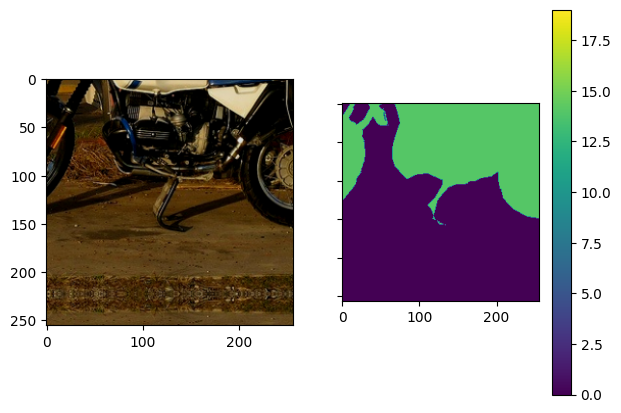

In [7]:
img,lbl = data_train[123]
fig,ax = plt.subplots(1,2, sharey=True, figsize=(7,5))
ax = ax.ravel()

ax[0].imshow(img.permute(1,2,0))
lbl_plot = ax[1].imshow(lbl.argmax(0),vmax = 19)
plt.colorbar(lbl_plot,ax = ax[1])
plt.show()

## Пункт 0. Гиперпараметры


Зададим гиперпараметры модели с помощью отдельной структуры *Hyper_params*

In [8]:
class Hyper_params:
  def __init__(self, model, model_params, optimizer, optimizer_params, sсheduler, sсheduler_params, loss, loss_params):
    self.model = model
    self.model_params = model_params
    self.optimizer = optimizer
    self.optimizer_params = optimizer_params
    self.sсheduler = sсheduler
    self.sсheduler_params = sсheduler_params
    self.loss = loss
    self.loss_params = loss_params

In [9]:
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

Создадим модель, которую будем далее обучать

In [10]:
params = Hyper_params(
    model="deeplabv3_mobilenet_v3_large",
    model_params={"weights": True, "num_classes": len(VOC_CLASSES), "progress": True},
    optimizer="AdamW",
    optimizer_params={"lr": 3e-5, "weight_decay": 1e-5},
    sсheduler="StepLR",
    sсheduler_params={"step_size": 1, "gamma": 0.5},
    loss="CrossEntropyLoss",
    loss_params={"label_smoothing": 1e-5}
)

In [11]:
model = torchvision.models.segmentation.__dict__[params.model](**params.model_params)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
100%|██████████| 42.3M/42.3M [00:01<00:00, 25.7MB/s]


Зададим оптимизатор

In [12]:
optim = torch.optim.__dict__[params.optimizer](model.parameters(), **params.optimizer_params)

Зададим DataLoader

In [13]:
train_dataloader = DataLoader(data_train, batch_size = 8, shuffle = True, num_workers = 2)

val_dataloader = DataLoader(data_val, batch_size = 8, shuffle = True, num_workers = 2)

In [14]:
crit = torch.nn.__dict__[params.loss](**params.loss_params)

In [15]:
model = model.cuda()

## Пункт 2. Расчёт метрики IoU

In [16]:
eps = 1e-6


def IoU(p, y):
    mask = p.softmax(1)
    cl = mask.argmax(1)
    cl_one_hot = torch.nn.functional.one_hot(cl, 21)
    cl_one_hot = torch.transpose(cl_one_hot, 1, 3)
    cl_one_hot = torch.transpose(cl_one_hot, 2, 3)

    iou_i = y * cl_one_hot
    iou_u = y + cl_one_hot

    s_i = iou_i.sum([2, 3])
    s_u = iou_u.count_nonzero([2, 3])
    return s_i / (s_u + eps)

## Пункт 3. Расчет метрики MIoU на основе IoU

In [17]:
def MIoU(p, y):
    iou = IoU(p, y)
    return iou.sum(1) / (iou.count_nonzero(1) + eps)

## Пункт 4 + 1. Обучение модели на приемлемое качество + валидация на каждой эпохе

In [18]:
t_losses = []
tloss = 0
v_losses = []
vloss = 0
v_mious = []
vmiou = np.empty(shape=[0])
next_desc = "first epoch"


for epoch in range(5):
  model.train()
  for img,lbl in tqdm(train_dataloader, desc=next_desc):
    img = img.cuda()
    lbl = lbl.cuda()
    predict = model(img)['out']
    loss = crit(predict, lbl)
    loss.backward()
    optim.step()
    optim.zero_grad()
    tloss += loss.detach().cpu().item() / len(train_dataloader)

  torch.cuda.empty_cache()

  model.eval()
  for img, lbl in tqdm(val_dataloader, desc=next_desc):
    with torch.no_grad():
      img = img.cuda()
      lbl = lbl.cuda()
      predict = model(img)["out"]
      loss = crit(predict, lbl)
      vloss += loss.detach().cpu().item() / len(val_dataloader)
      miou_bc = MIoU(predict, lbl).cpu().numpy()
      vmiou = np.hstack((vmiou, miou_bc))

  torch.cuda.empty_cache()

  t_losses+= [tloss]
  v_losses+= [vloss]
  v_mious+= [vmiou.mean()]

  next_desc = f'Epoch: [{epoch+1}], previous tloss: [{tloss:.3f}], previous vloss: [{vloss:.3f}], previous vmiou: [{vmiou.mean():.3f}]'
  tloss = 0
  vloss = 0
  vmiou = np.empty(shape=[0])

first epoch:   0%|          | 0/183 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
first epoch: 100%|██████████| 182/182 [03:55<00:00,  1.29s/it]
Epoch: [1], previous tloss: [0.431], previous vloss: [0.284], previous vmiou: [0.737]: 100%|██████████| 183/183 [04:36<00:00,  1.51s/it]
Epoch: [1], previous tloss: [0.431], previous vloss: [0.284], previous vmiou: [0.737]: 100%|██████████| 182/182 [03:50<00:00,  1.26s/it]
Epoch: [2], previous tloss: [0.377], previous vloss: [0.264], previous vmiou: [0.737]: 100%|██████████| 183/183 [04:32<00:00,  1.49s/it]
Epoch: [2], previous tloss: [0.377], previous vloss: [0.264], previous vmiou: [0.737]: 100%|██████████| 182/182 [03:51<00:00,  1.27s/it]
Epoch: [3], previous tloss: [0.343], previous vloss: [0.257], previous vmiou: [0.740]: 100%|██████████| 1

Изобразим результат с помощью графиков

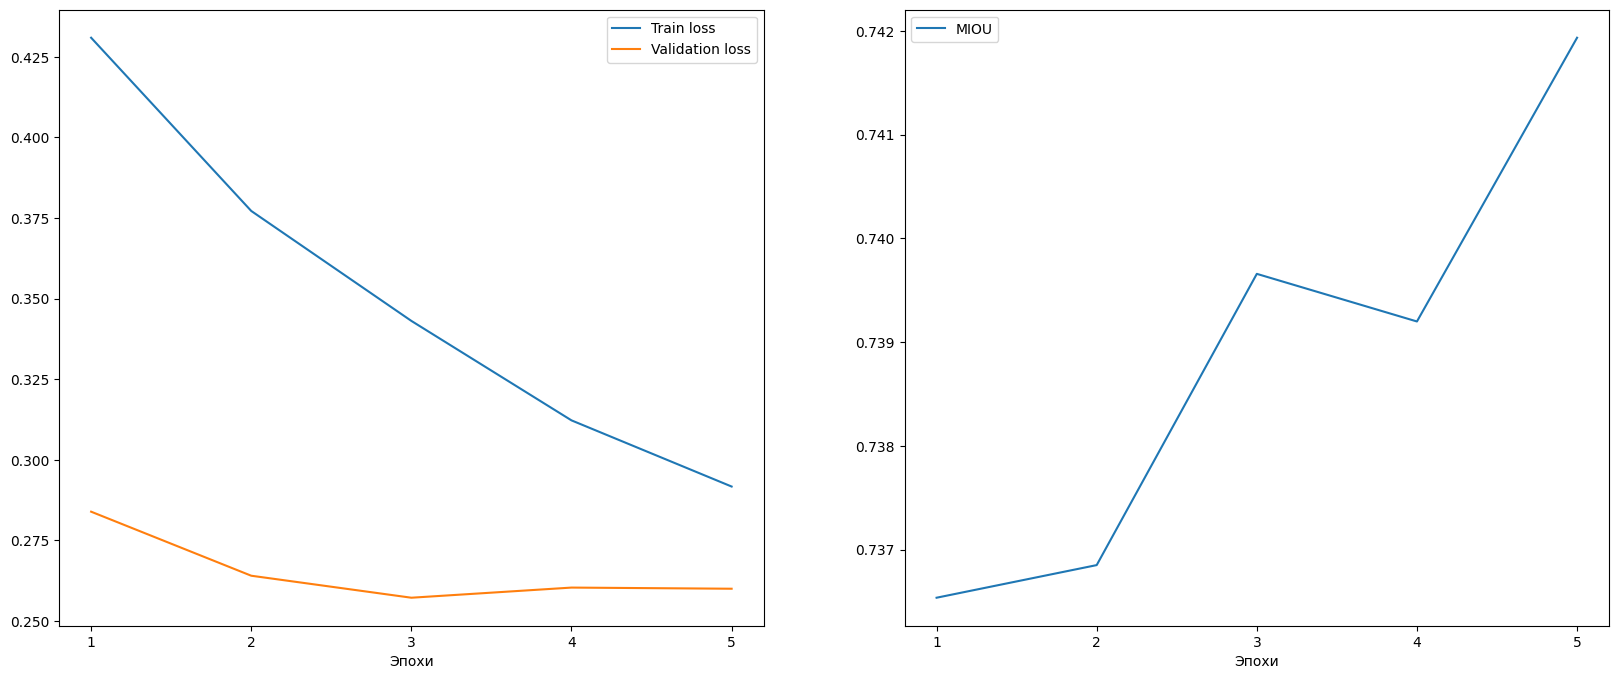

In [25]:
figure = plt.figure(figsize=(20, 8))
ep = list(range(1, 6)),

axes = figure.add_subplot(121)
plt.plot(ep[0], t_losses, label="Train loss")
plt.plot(ep[0], v_losses, label="Validation loss")
plt.xticks(ep[0])
plt.xlabel("Эпохи")
plt.legend()

axes = figure.add_subplot(122)
plt.plot(ep[0], v_mious, label="MIOU")
plt.xticks(ep[0])
plt.xlabel("Эпохи")
plt.legend()
plt.show()


Отберём лучшее качество на валидации и изобразим результат с помощью гистограммы

In [28]:
n_cl = len(VOC_CLASSES)

last_iou = np.zeros((n_cl,))
cnt = np.zeros((n_cl,))

iou_ind = []
ious = np.empty(shape=[0, 21])

model.eval()
for i, (img, lbl) in enumerate(tqdm(data_val, desc="Processing results")):
    pred = model(img.clone().detach().reshape((1, 3, 256, 256)).cuda())["out"]
    iou_i = IoU(pred, lbl.cuda())[0].detach().cpu().numpy()
    lbl_cl = np.unique(lbl.argmax(0))
    ious = np.vstack((ious, iou_i))

    lbl_cl_no_back = lbl_cl[1:]
    iou_ind.append([-iou_i[lbl_cl_no_back].mean(), i])

    cnt[lbl_cl] += 1
    last_iou[lbl_cl] += iou_i[lbl_cl]

last_iou /= cnt
sorted_inds = []
for iou, i in sorted(iou_ind):
    sorted_inds.append(i)

best_classes = ious.argmax(0)

Processing results: 100%|██████████| 1449/1449 [04:42<00:00,  5.14it/s]


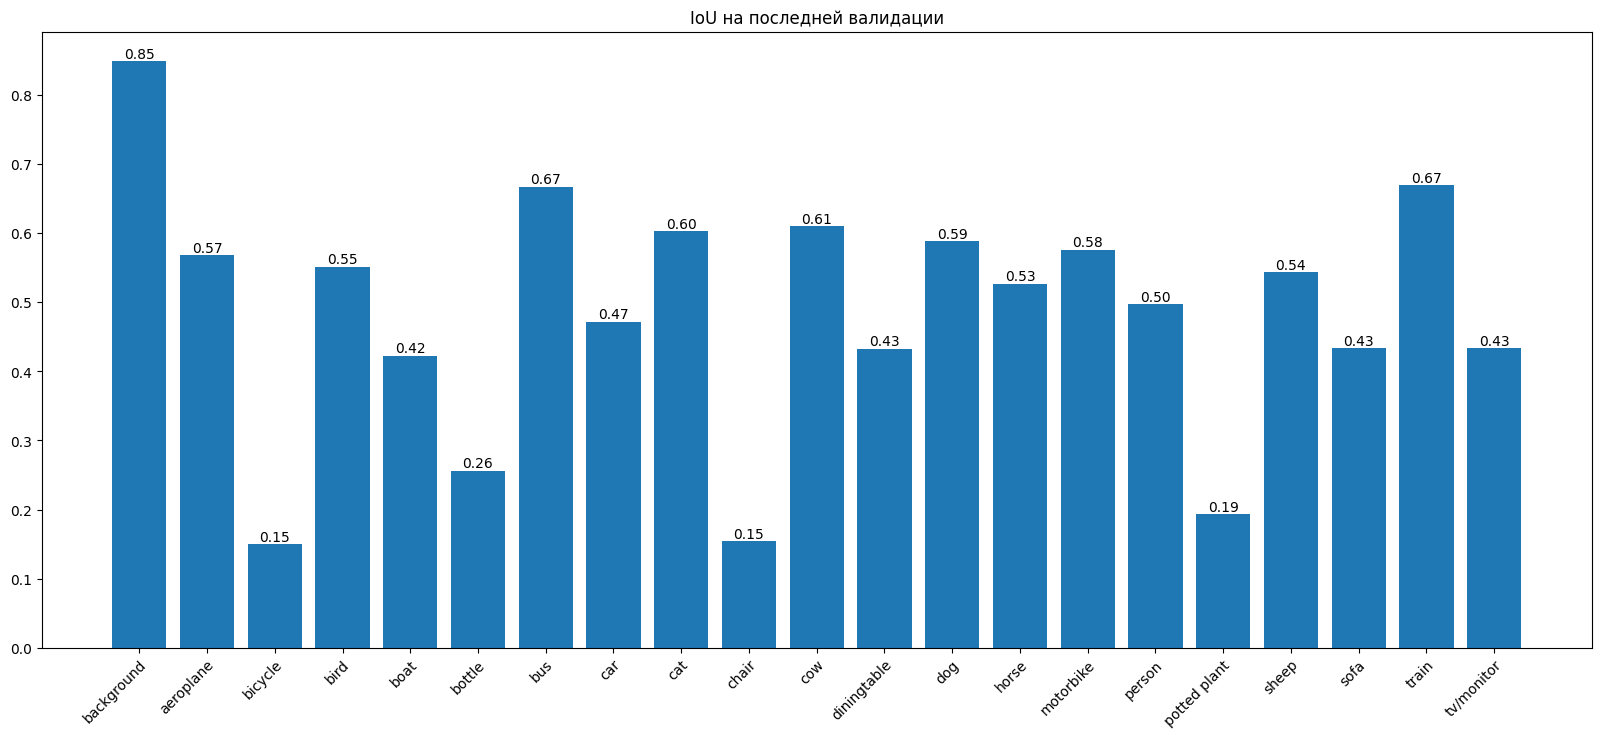

In [30]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.set_xticks(range(n_cl), labels=VOC_CLASSES)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.title("IoU на последней валидации")
bars = plt.bar(range(n_cl), last_iou)
plt.bar_label(bars, labels=[("%.2lf" % elem) for elem in last_iou])
plt.show()

## Пункт 5. Отобор двух картинок на основе метрики IoU из 3 квантилей

In [48]:
def draw_preds(ids, s):
    n = len(ids)
    fig, ax = plt.subplots(n, 3, sharey=True, figsize=(3 * 3, n * 3))

    for i, elem in enumerate(ids):
        img = data_val[elem][0]
        lbl = data_val[elem][1]
        pred = (
            model(img.clone().detach().reshape((1, 3, 256, 256)).cuda())["out"]
            .cpu()
            .softmax(1)[0]
        )
        ax[i, 0].imshow(img.permute(1, 2, 0))
        ax[i, 1].imshow(pred.argmax(0), vmin=0, vmax=20)
        ax[i, 2].imshow(lbl.argmax(0), vmin=0, vmax=20)
    for i in range(n):
        for j in range(3):
            ax[i, j].get_xaxis().set_visible(False)
            ax[i, j].get_yaxis().set_visible(False)
    plt.suptitle(s)
    plt.tight_layout()
    plt.show()

In [37]:
def best_from_sorted(l, r, k, s):
    n = len(sorted_inds)
    ids = np.random.choice(sorted_inds[int(l * n) : int(r * n)], k)
    draw_preds(ids, s)

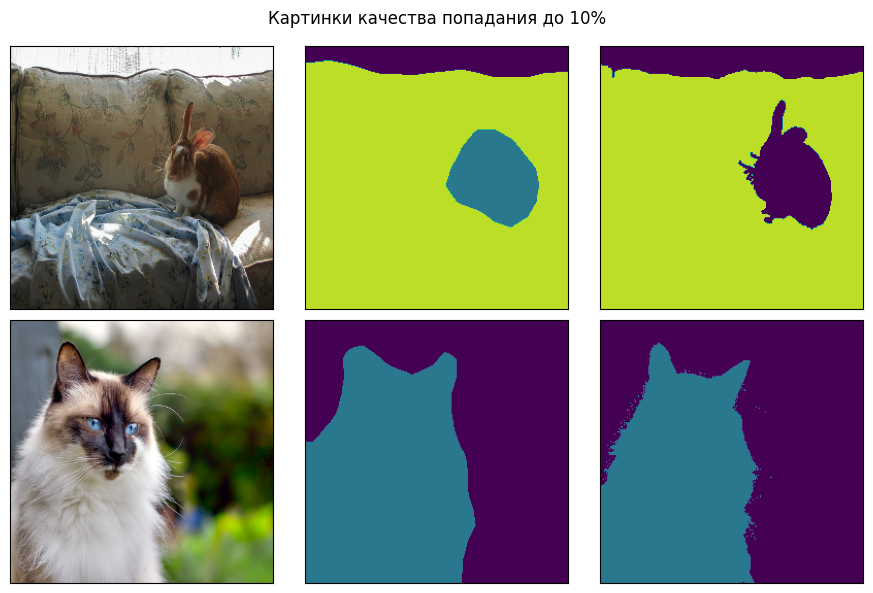

In [57]:
best_from_sorted(0.0, 0.1, 2, "Картинки качества попадания до 10%")

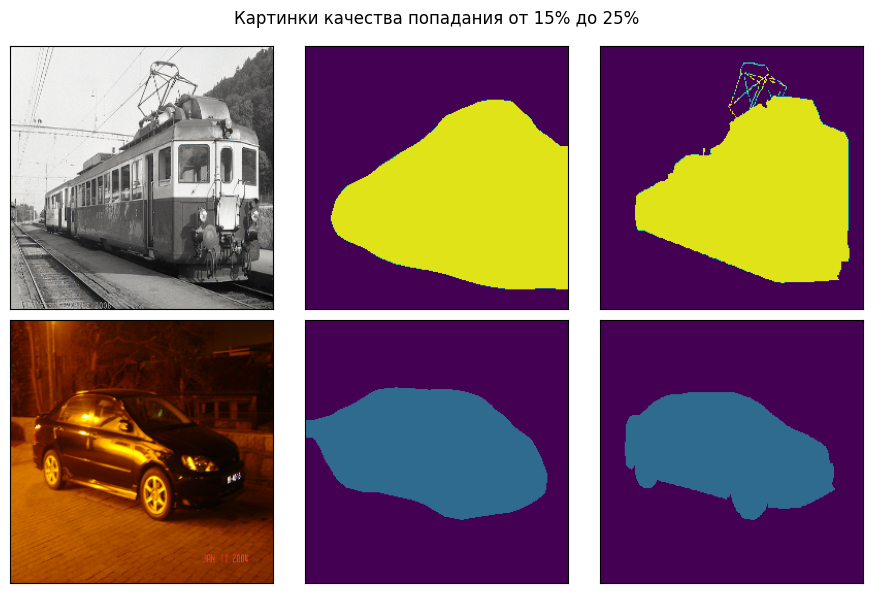

In [58]:
best_from_sorted(0.15, 0.25, 2, "Картинки качества попадания от 15% до 25%")

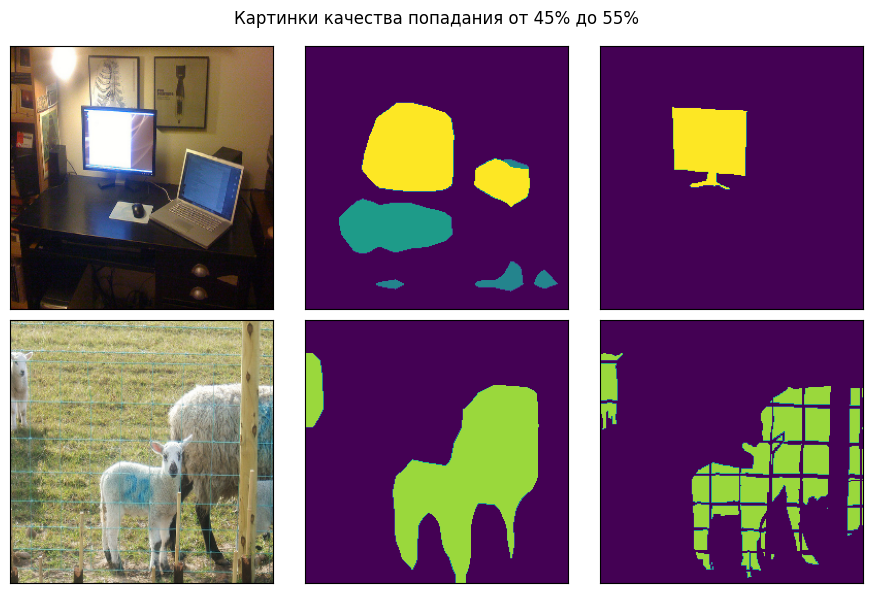

In [59]:
best_from_sorted(0.45, 0.55, 2, "Картинки качества попадания от 45% до 55%")

## Пункт 6. Отобор лучшей картинки по качеству IoU из трёх классов

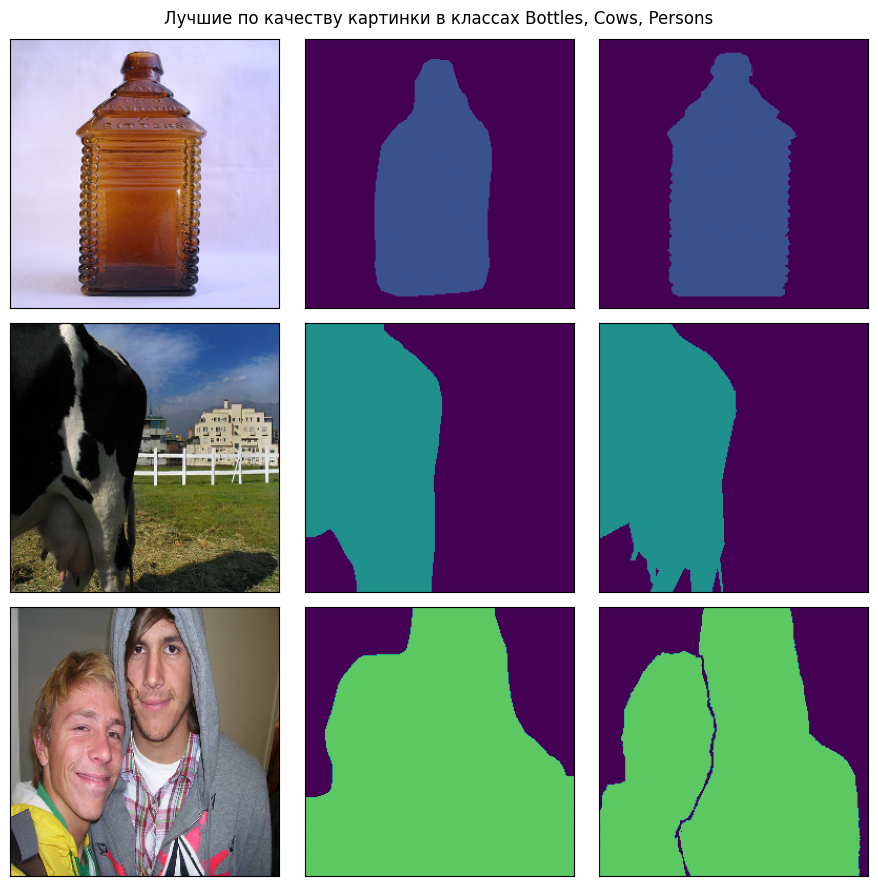

In [65]:
draw_preds(
    [
        best_classes[5],
        best_classes[10],
        best_classes[15]
    ],
    "Лучшие по качеству картинки в классах Bottles, Cows, Persons",
)

## Пункт 7. Таблица IoU в развертке по кадому классу для модели

In [88]:
import pandas as pd

ious_arr = torch.Tensor(v_mious)
shape = ious_arr.shape

pd.DataFrame(ious_arr.reshape((shape[0], shape[1])).numpy(), columns=VOC_CLASSES)

        background   aeroplane    bicycle     bird      boat      bottle      bus      car      cat      chair    ...      train     tv/monitor
0       0.869234     0.80561      NaN         NaN       NaN       NaN         NaN      NaN      NaN      NaN      ...      NaN       NaN
1       0.769123     NaN          NaN         NaN       NaN       NaN         NaN      NaN      NaN      NaN      ...      0.827149  NaN
2       0.849123     NaN          NaN         NaN       0.460231  NaN         NaN      NaN      NaN      NaN      ...      NaN       NaN
3       0.340123     NaN          NaN         NaN       NaN       NaN         NaN      NaN      NaN      NaN      ...      0.629181  NaN
4       0.620128     NaN          0.491212    NaN       NaN       NaN         NaN      NaN      NaN      NaN      ...      NaN       NaN
...     ...          ...          ...         ...       ...       ...         ...      ...      ...      ...      ...      ...       ...
1444    0.000000     NaN          

**Вывод:** в процессе лабораторной работы я познакомился с тем, что такое многоклассовая семантическая сегментация на датасете Pascal VOC. Концепция данной технологии показалась довольно интересной несмотря на то, что модели не всегда удавалось точно выделять нужные объекты на фото. Думаю, проблема кроется не только в несовершнестве модели, на это также может влиять и качество картинок. Тем не менее, работать было довольно увлекательно.